In [1]:
import sys
import os
from tqdm import tqdm

sys.path.append(os.path.abspath(".."))

from time import perf_counter

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist


from src.sampler import HMCSampler, MetropolisHastingsSampler
from src.density import NealsFunnel


# Define distribution

In [2]:
dim = 2

neals_funnel = NealsFunnel(dim=dim, sigma_y=3.0)
hmc = HMCSampler(neals_funnel)

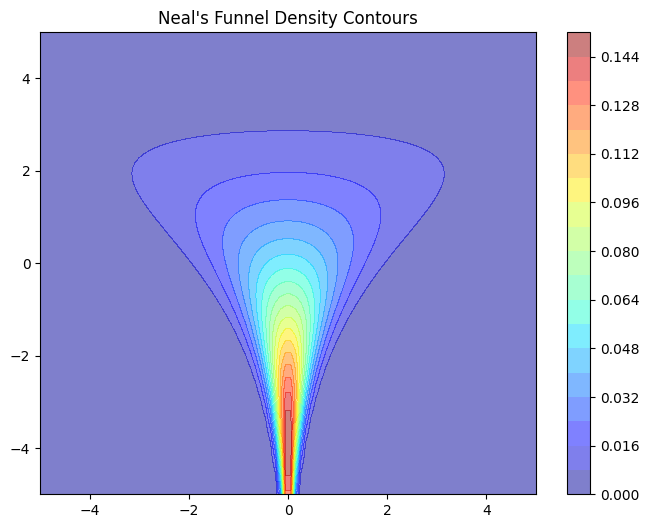

In [3]:
# plot custom_gaussian.f() function between [-5, -5, 5, 5]
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = np.empty_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = neals_funnel(np.array([Y[i, j], X[i, j]]))

fig, ax = plt.subplots(figsize=(8, 6))
cs = ax.contourf(X, Y, Z, levels=20, cmap="jet", alpha=0.5)
ax.set_title("Neal's Funnel Density Contours")
plt.colorbar(cs)
plt.show()


# Hamiltonian Monte Carlo Sampling

## Leapfrog a couple of samples

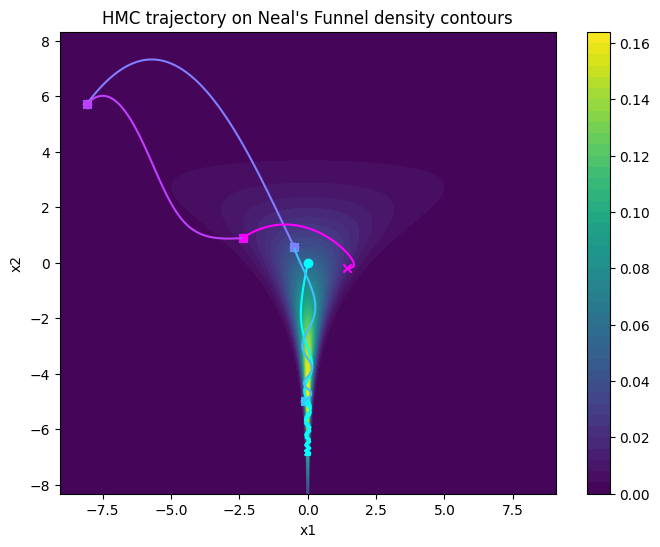

In [4]:
# Single long trajectory for visualisation
q0 = np.array([0.0] * dim)
n_paths = 5
paths = []
for _ in range(n_paths):
    p0 = np.random.normal(size=dim)
    # qT, pT, path = leapfrog(
    #     q0, p0, step_size=0.05, n_steps=100, grad_U=grad_U, return_path=True
    # )
    q0, pT, path = hmc.leapfrog(x=q0, p=p0, leapfrog_steps=100, step_size=0.05)
    paths.append(path)

# Plot results
# Grid and contour plot
x_lim = (
    max(
        abs(np.min([path[:, 1].min() for path in paths])),
        abs(np.max([path[:, 1].max() for path in paths])),
    )
    + 1
)
y_lim = (
    max(
        abs(np.min([path[:, 0].min() for path in paths])),
        abs(np.max([path[:, 0].max() for path in paths])),
    )
    + 1
)

xs = np.linspace(-x_lim, x_lim, 500)
ys = np.linspace(-y_lim, y_lim, 500)

X, Y = np.meshgrid(xs, ys)
Z = np.empty_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = neals_funnel(np.array([Y[i, j], X[i, j]]))


fig, ax = plt.subplots(figsize=(8, 6))
cs = ax.contourf(X, Y, Z, levels=50, cmap="viridis")

# ax.clabel(cs, inline=True, fontsize=8)
colors = plt.cm.cool(np.linspace(0, 1, n_paths))
for i, path in enumerate(paths):
    ax.plot(path[:, 1], path[:, 0], color=colors[i])
    ax.scatter(path[0, 1], path[0, 0], marker="o", color=colors[i])
    ax.scatter(path[-1, 1], path[-1, 0], marker="x", color=colors[i])
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("HMC trajectory on Neal's Funnel density contours")

plt.colorbar(cs)
plt.show()

## Sample points

In [19]:
# np.random.seed(0)

dim = 2
n_samples = 1000
leapfrog_steps = 20
step_size = 0.1
initial_q = np.array([0.0] * dim)

start = perf_counter()
samples_hmc, acceptance_rate_hmc = hmc.sample(
    n_samples,
    leapfrog_steps,
    initial_q,
    step_size,
    dim,
)
time_hmc = perf_counter() - start

print(f"HMC sampling took {time_hmc:.3f} seconds.")
print(f"HMC acceptance rate: {acceptance_rate_hmc:.3f}")

HMC sampling took 0.144 seconds.
HMC acceptance rate: 0.982


## Plot samples

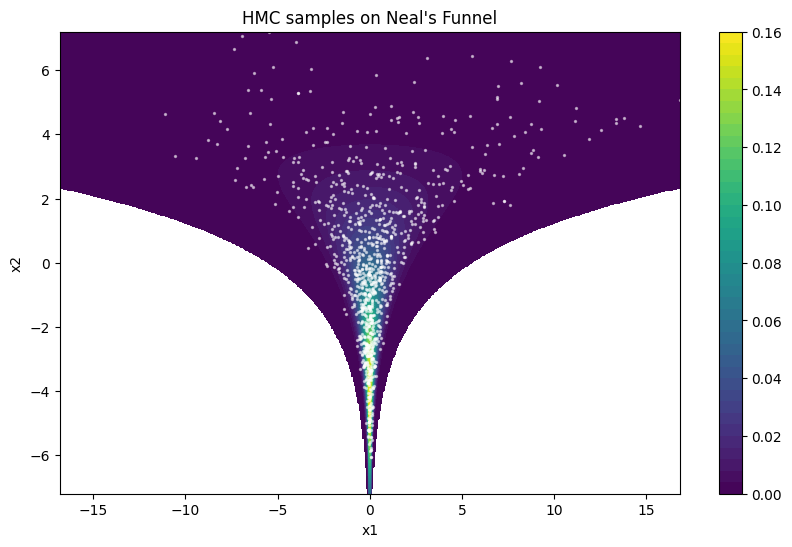

In [21]:
# Plot samples on top of contour plot
fig, ax = plt.subplots(figsize=(10, 6))

min_x, max_x = min(samples_hmc[:, 1]), max(samples_hmc[:, 1])
x_lim = max(abs(min_x), abs(max_x))
min_y, max_y = min(samples_hmc[:, 0]), max(samples_hmc[:, 0])
y_lim = max(abs(min_y), abs(max_y))

xs = np.linspace(-x_lim, x_lim, 500)
ys = np.linspace(-y_lim, y_lim, 500)

X, Y = np.meshgrid(xs, ys)
Z = np.empty_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = neals_funnel(np.array([Y[i, j], X[i, j]]))
Z = np.ma.masked_where(np.isclose(Z, 0), Z)

cs = ax.contourf(X, Y, Z, levels=50, cmap="viridis")
ax.scatter(samples_hmc[:, 1], samples_hmc[:, 0], color="w", s=2, alpha=0.5, zorder=2)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("HMC samples on Neal's Funnel")
plt.colorbar(cs)
plt.show()

# Metropolis Hastings Sampling

In [7]:
metropolis_sampler = MetropolisHastingsSampler(neals_funnel)

In [22]:
# Plot the full path of Metropolis samples
q0 = np.array([0.0] * dim)
start = perf_counter()
samples_metropolis, acc_rate = metropolis_sampler.sample(
    n_samples,
    proposal_scale=0.5,
    dim=dim,
    initial_q=q0,
)
time_metropolis = perf_counter() - start

print(f"Metropolis sampling took {time_metropolis:.3f} seconds.")
print(f"Metropolis acceptance rate: {acc_rate:.3f}")

Metropolis sampling took 0.018 seconds.
Metropolis acceptance rate: 0.708


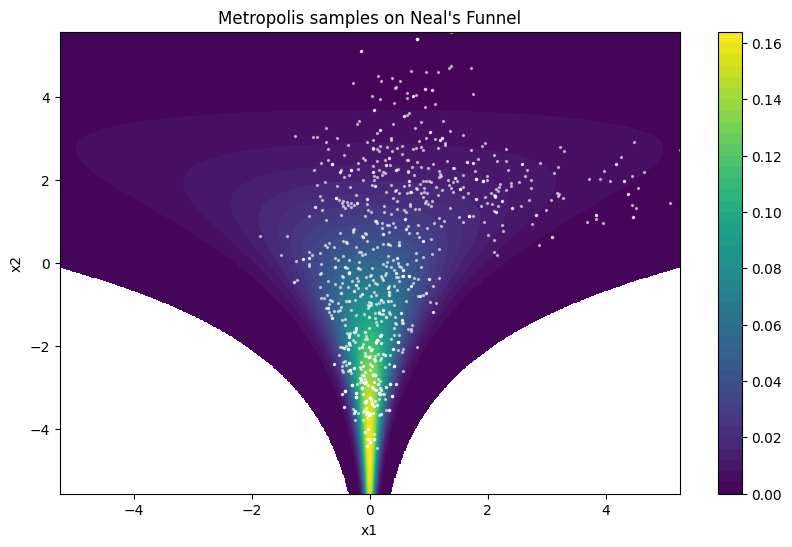

In [23]:
# Plot samples on top of contour plot
fig, ax = plt.subplots(figsize=(10, 6))

min_x, max_x = min(samples_metropolis[:, 1]), max(samples_metropolis[:, 1])
x_lim = max(abs(min_x), abs(max_x))
min_y, max_y = min(samples_metropolis[:, 0]), max(samples_metropolis[:, 0])
y_lim = max(abs(min_y), abs(max_y))

xs = np.linspace(-x_lim, x_lim, 500)
ys = np.linspace(-y_lim, y_lim, 500)

X, Y = np.meshgrid(xs, ys)
Z = np.empty_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = neals_funnel(np.array([Y[i, j], X[i, j]]))
Z = np.ma.masked_where(np.isclose(Z, 0), Z)

cs = ax.contourf(X, Y, Z, levels=50, cmap="viridis")
ax.scatter(
    samples_metropolis[:, 1],
    samples_metropolis[:, 0],
    color="w",
    s=2,
    alpha=0.5,
    zorder=2,
)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("Metropolis samples on Neal's Funnel")
plt.colorbar(cs)
plt.show()


# Sampling Comparison

## MMD 

In [10]:
def gaussian_kernel_matrix(X, Y, sigma):
    """
    Computes exp(-||x - y||^2 / (2 sigma^2)) for all x in X, y in Y.
    """
    d2 = cdist(X, Y, "sqeuclidean")
    return np.exp(-d2 / (2.0 * sigma**2))


def median_heuristic(Z):
    """
    Median heuristic for kernel bandwidth selection.

    Z is an array of shape (N, D). We compute pairwise
    distances and use median of squared distances.
    """
    d2 = cdist(Z, Z, "sqeuclidean")
    # Remove zeros on diagonal
    d2 = d2[d2 > 0]
    return np.sqrt(0.5 * np.median(d2))


def mmd2_unbiased(X, Y, sigma=None):
    """
    Unbiased estimator of MMD^2 with Gaussian kernel.
    X: (n, d)
    Y: (m, d)

    Returns: float
    """
    X = np.asarray(X)
    Y = np.asarray(Y)
    n, d = X.shape
    m, _ = Y.shape

    # Choose bandwidth if not given
    if sigma is None:
        Z = np.vstack([X, Y])
        sigma = median_heuristic(Z)

    Kxx = gaussian_kernel_matrix(X, X, sigma)
    Kyy = gaussian_kernel_matrix(Y, Y, sigma)
    Kxy = gaussian_kernel_matrix(X, Y, sigma)

    # Remove diagonal terms for unbiased estimator
    sum_Kxx = np.sum(Kxx) - np.sum(np.diag(Kxx))
    sum_Kyy = np.sum(Kyy) - np.sum(np.diag(Kyy))

    mmd2 = (
        sum_Kxx / (n * (n - 1)) + sum_Kyy / (m * (m - 1)) - 2.0 * np.sum(Kxy) / (n * m)
    )

    return mmd2


def sample_funnel(dim=10, sigma_y=3.0, n=100000):
    y = np.random.normal(0, sigma_y, size=(n, 1))
    x = np.random.normal(0, np.exp(y / 2), size=(n, dim - 1))
    return np.hstack([y, x])


In [15]:
dims = range(2, 153, 10)

hmc_mmd2s = []
hmc_acceptancerates = []
metropolis_mmd2s = []
metropolis_acceptancerates = []
baselines = []

for dim in tqdm(dims):
    initial_q = np.array([0.0] * dim)
    leapfrog_steps = 100
    step_size = 0.2 / dim
    n_samples = 10 * dim

    neals_funnel_highdim = NealsFunnel(dim=dim, sigma_y=3.0)

    hmc_highdim = HMCSampler(neals_funnel_highdim)
    metropolis_sampler_highdim = MetropolisHastingsSampler(neals_funnel_highdim)

    samples_hmc_highdim, accepted_hmc = hmc_highdim.sample(
        n_samples,
        leapfrog_steps,
        initial_q,
        step_size,
        dim,
    )

    samples_metropolis_highdim, accepted_metropolis = metropolis_sampler_highdim.sample(
        n_samples,
        proposal_scale=1 / dim,
        dim=dim,
        initial_q=initial_q,
    )
    reference_samples = sample_funnel(dim=dim, sigma_y=3.0, n=1000)

    mmd2_hmc = mmd2_unbiased(samples_hmc_highdim, reference_samples)
    mmd2_metropolis = mmd2_unbiased(samples_metropolis_highdim, reference_samples)

    hmc_mmd2s.append(mmd2_hmc)
    hmc_acceptancerates.append(accepted_hmc)
    metropolis_mmd2s.append(mmd2_metropolis)
    metropolis_acceptancerates.append(accepted_metropolis)
    baselines.append(
        mmd2_unbiased(np.zeros_like(samples_hmc_highdim), reference_samples)
    )

100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


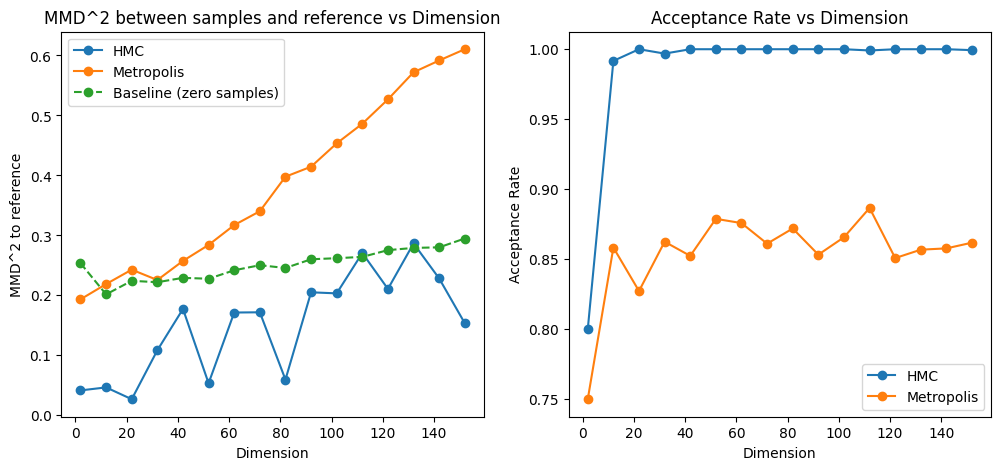

In [16]:
# Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(dims, hmc_mmd2s, marker="o", label="HMC")
ax[0].plot(dims, metropolis_mmd2s, marker="o", label="Metropolis")
ax[0].plot(dims, baselines, marker="o", label="Baseline (zero samples)", linestyle="--")
ax[0].set_xlabel("Dimension")
ax[0].set_ylabel("MMD^2 to reference")
ax[0].set_title("MMD^2 between samples and reference vs Dimension")
ax[0].legend()

ax[1].plot(dims, hmc_acceptancerates, marker="o", label="HMC")
ax[1].plot(dims, metropolis_acceptancerates, marker="o", label="Metropolis")
ax[1].set_xlabel("Dimension")
ax[1].set_ylabel("Acceptance Rate")
ax[1].set_title("Acceptance Rate vs Dimension")
ax[1].legend()

plt.show()